<function matplotlib.pyplot.show(close=None, block=None)>

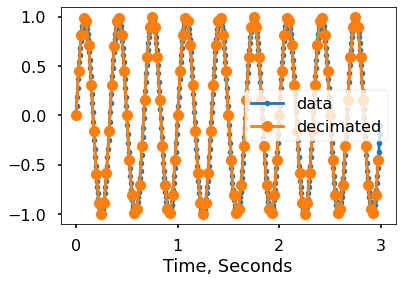

In [13]:
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
import rheosys as rhs



#sampling time settings
wave_duration = 3
sample_rate = 200
freq = 3
q_factor = 5
samples = wave_duration*sample_rate
samples_decimated = int(samples/q_factor)

#Frequency input selection from rheosys
x_exact = np.linspace(0, wave_duration, samples, endpoint=False)
y_exact = np.sin(x_exact*np.pi*freq*2)


#Sampling frequency to time vector use of scipy DECIMATE
x_vect_time = np.linspace(0, wave_duration, samples_decimated, endpoint=False)
y_vect_time = signal.decimate(y_exact,q_factor,)


#Figure plot of the corresponding fr
plt.plot(x_exact, y_exact, '.-', x_vect_time, y_vect_time, 'o-')
plt.xlabel('Time, Seconds')
plt.legend(['data', 'decimated'], loc='best')
plt.show


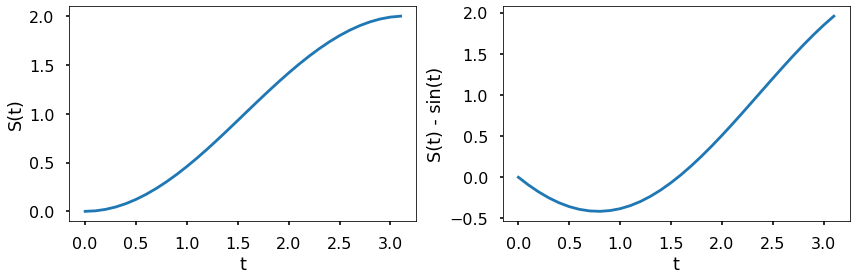

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import rheosys as rhs

plt.style.use('seaborn-poster')


F = lambda t, s: np.sin(t)

t_eval = np.arange(0, np.pi, 0.1)
sol = solve_ivp(F, [0, np.pi], [0], t_eval=t_eval)

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.subplot(122)
plt.plot(sol.t, sol.y[0] - np.sin(sol.t))
plt.xlabel('t')
plt.ylabel('S(t) - sin(t)')
plt.tight_layout()
plt.show()

In [ ]:
class excitation():
    #Excitation signals used as input for the analysis,
    #   input must be defined as one value with the unit of ...
    #   output is defined with the unit of ...

    def sin (self):
        ouput=np.sin(x)
        return ouput

    def cos (self):
        ouput=np.sin(x)
        return ouput

class ode():
    #ODE included in rheological models that include mass-spring damper systems to describe the material properties
    #input variables needed for these solvers ... with units ...
    #output variables given from these solvers ... with units ...

    def maxwell():

    def kelvin():

